In [1]:
# 2017_07_20 .............. Primary_testset_preview
# Smooth (100) the raw spectrogram. Pick the max amp. Apply linear and calculate other statistical parameters

In [2]:
from __future__ import division

import cStringIO
import glob
import json
import requests
import ibmseti
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
import re
%matplotlib inline
import matplotlib.image as mpimg
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import axes3d

In [3]:
mydatafolder = os.path.join( os.environ['PWD'], 'my_data_folder' )
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)

# Create folder for zip to extract to
setiDataDir = mydatafolder + '/data_preview'
if os.path.exists(setiDataDir) is False:
    os.makedirs(setiDataDir)
    
# Create folder for future spectrograms
outputpng_folder = mydatafolder + '/png_preview'
if os.path.exists(outputpng_folder) is False:
    os.makedirs(outputpng_folder)

In [4]:
!ls -al "$mydatafolder"

total 11365368
drwx------ 8 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Jul 31 17:24 .
drwxr-x--- 9 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Jul 31 01:39 ..
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 1157840757 Jul 20 15:38 basic4.zip
drwx------ 2 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Jul 31 17:24 data_preview
drwx------ 3 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Jul 20 17:52 data_psm
drwx------ 2 sbb5-1ce73915b4fc6f-b77eb2b8b2db users     524288 Jul 10 14:00 png
drwx------ 2 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Jul 31 17:24 png_preview
drwx------ 2 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Jul 20 17:51 png_psm
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 2023055699 Jul 28 13:54 primary_small_v3.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  697495727 Jul 31 17:20 primary_testset_preview_v3.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users     365027 Jul 28 13:54 public_list_primary_v3_small_21june

In [5]:
zz = zipfile.ZipFile(mydatafolder + '/' + 'primary_testset_preview_v3.zip')
primary_testset_preview_v3list = zz.namelist()
print len(primary_testset_preview_v3list)

2415


In [6]:
# Extract Data folder
def unzip_data(dest, zipf):
    # zipf = array of zip files     
    for i in zipf:
        zz = zipfile.ZipFile(mydatafolder + '/' + i )
        zz.extractall(dest)

In [7]:
unzip_data(setiDataDir, ['primary_testset_preview_v3.zip'])
# when using the larger dataset, you will have multiple zip files. Pass an array of those zip files to unzip_data

In [8]:
# Choose your data set!
workingDataDir = setiDataDir
workingIndexFile = os.path.join( mydatafolder + '/public_list_primary_v3_testset_preview.csv' )

In [53]:
# use a smoothing function
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#Use `ibmseti`, or other methods, to draw the spectrograms
def draw_spectrogram(data):
    # use ibmseti library to calculate spectrogram
    aca = ibmseti.compamp.SimCompamp(data)
    spec = aca.get_spectrogram()
    
    # Smoothing seems to work the best, so smooth the entire spectrogram
    # 'spec' is of type 'numpy.ndarray' & 'smooth(spec)' is of type 'list'
    spec2 = np.asarray([smooth(spec[i],100) for i in range(32)]) 
    
    # Calculate the Max signal for each time slice and for each freq slice
    maxAmps_Freq = spec2.argmax(1)
    maxAmps_Time = np.arange(31,-1,-1)
    maxAmp = spec2.max()
    
    # Fit a staright line to the spectrogram signal
    lin_slope, lin_intercept, lin_r_value, lin_p_value, lin_std_err = scipy.stats.linregress(maxAmps_Freq, maxAmps_Time)
    
    # Calculate Mean, Median, Std.Dev. along time axis
    mean_Time = np.mean(spec2.max(axis=1))
    median_Time = np.median(spec2.max(axis=1))
    ratio_Time = mean_Time/median_Time
    spread_Time = abs(mean_Time-median_Time)/median_Time #not better than ratio_time
    std_dev_Time = np.std(spec2.max(axis=1))
    
    #Number of MaxAmps > (median + std.dev)
    above_cnt = sum([1 if i>(median_Time+(2*std_dev_Time)) else 0 for i in spec2.max(axis=1)])
    above_max = max([(i-median_Time) if i>(median_Time+std_dev_Time) else 0 for i in spec2.max(axis=1)])
    
    #Calculate Std.Dev. along Freq axis
    std_dev_Freq = np.std(spec2.argmax(1))
    
    #Sum of differences
    sum_diff = sum(map(abs,[(spec2.argmax(1)[i+1]-spec2.argmax(1)[i]) for i in range(31)]))
    
    #Switch directions
    switchbacks = sum([1 if (spec2.argmax(1)[i+2]>spec2.argmax(1)[i+1] and spec2.argmax(1)[i]>spec2.argmax(1)[i+1])\
 or (spec2.argmax(1)[i+2]<spec2.argmax(1)[i+1] and spec2.argmax(1)[i]<spec2.argmax(1)[i+1]) else 0 for i in range(30)])
    
    return aca.header(), lin_slope, lin_intercept, lin_r_value, lin_p_value, lin_std_err, maxAmp, ratio_Time, \
spread_Time, std_dev_Time, above_cnt, above_max, std_dev_Freq, sum_diff, switchbacks

def convert_to_spectrogram_and_save(row):
    
    try:
        uuid, classification = row.split(',')
    except:
        uuid = row #this handles the test data since it doesn't have "SIGNAL_CLASSIFICATION" in index file
        classification = 'unknown: test data'
        
    #create path to local data file
    filename = uuid + '.dat'
    filepath = os.path.join(workingDataDir + '/primary_testset_preview_v3', filename)
    
    #retrieve that data file
    rawdata = open(filepath).read()
    
    header, slope, intercept, r_value, p_value, std_err, maxAmp, ratio, spread, std_dev, above_cnt, above_max, \
    std_dev_Freq, sum_diff, switchbacks = draw_spectrogram(rawdata)

    return (header, slope, intercept, r_value, p_value, std_err, maxAmp, ratio, spread, std_dev, above_cnt, \
            above_max, std_dev_Freq, sum_diff, switchbacks)

In [54]:
rdd = sc.textFile(workingIndexFile, 30).filter(lambda x: x.startswith('UUID') is False) #the filter removes the header
print(rdd.count())
rdd.take(5)

2414


[u'c4be0ef717f34e53a568cd781d027c46',
 u'dbe38b359e70efb1a5fc2ea7bc4c619c',
 u'f6f3b38df018140781209e714b55c1f1',
 u'7277d1256605c04de7d993789e2b5dce',
 u'afa01f29afaa6b3b686273792eb3fb4a']

In [55]:
# 0-header, 1-slope, 2-intercept, 3-r_value, 4-p_value, 5-std_err, 6-maxAmp, 7-ratio, 8-spread, 9-std_dev, 
# 10-above_cnt, 11-above_max, 12-std_dev_Freq, 13-sum_diff, 14-switchbacks
#results = rdd.map(convert_to_spectrogram_and_save).take(5)
results = rdd.map(convert_to_spectrogram_and_save).collect()

In [12]:
print(len(results[2])) # check how many parameters are created for each spectrogram
print(len(results)) # check the total number of signals

15
2414


In [13]:
index=1300 # pick a signal to verify its parameters
print(type(results[index]))
print(results[index])

<type 'tuple'>
({u'uuid': u'5280af9e781c9658ea26e08ce2d917f4'}, 0.00020315485827065405, 14.86025900271639, 0.04026758147988322, 0.8267952221081819, 0.00092036194622307523, 7989406.3628913527, 1.3130741546338738, 0.31307415463387378, 1605672.7094483878, 8, 5328146.9266151125, 1830.1029766855847, 53799, 17)


In [56]:
# Split the data into 'lists' of values
# 0-header, 1-slope, 2-intercept, 3-r_value, 4-p_value, 5-std_err, 6-maxAmp, 7-ratio, 8-spread, 9-std_dev,
# 10-above_cnt, 11-above_max, 12-std_dev_Freq, 13-sum_diff, 14-switchbacks

# Separate parameters in separate lists
#Class = [results[j][0]['signal_classification'] for j in range(len(results))]
uuid = [results[j][0]['uuid'] for j in range(len(results))]
Slope = [results[j][1] for j in range(len(results))]
R_Val = [results[j][3] for j in range(len(results))]
P_Val = [results[j][4] for j in range(len(results))]
Max_Amp = [results[j][6] for j in range(len(results))]
Ratio_Time = [results[j][7] for j in range(len(results))]
Spread_Time = [results[j][8] for j in range(len(results))]
Std_Dev_Time = [results[j][9] for j in range(len(results))]
AboveCnt_Time = [results[j][10] for j in range(len(results))]
AboveMax_Time = [results[j][11] for j in range(len(results))]
Std_Dev_Freq = [results[j][12] for j in range(len(results))]
Sum_Diff = [results[j][13] for j in range(len(results))]
Switchbacks = [results[j][14] for j in range(len(results))]

In [16]:
print(len(Ratio_Time))
print(type(AboveCnt_Time))

2414
<type 'list'>


In [18]:
# Write DSP parameter values to text file
spreadtimefile = open('preview_spreadtime.txt', 'w')
for item in Spread_Time:
  spreadtimefile.write("%s\n" % item)
spreadtimefile.close()

In [159]:
!ls -al 

total 47291544
drwxr-x---  9 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Aug  1 01:14 .
drwxr-x--- 11 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Jul 27 01:36 ..
drwx------  5 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Jun 10 18:15 benders
drwx------  4 sbb5-1ce73915b4fc6f-b77eb2b8b2db users       4096 Jun 11 15:19 bendersarun
-rw-------  1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 3773448192 May 24 16:56 core.20170524.165605.3307.0001.dmp
-rw-------  1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 3482697728 May 25 00:08 core.20170525.000839.29830.0001.dmp
-rw-------  1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 4664553472 May 28 16:22 core.20170528.162218.28855.0001.dmp
-rw-------  1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 2440921088 May 28 19:43 core.20170528.194328.8797.0001.dmp
-rw-------  1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 4071268352 May 29 03:24 core.20170529.032401.13718.0001.dmp
-rw-------  1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 2296918016 Jul  2 19:03 core.2017070

In [20]:
Class[5998:6002]

NameError: name 'Class' is not defined

In [251]:
# Locate specific signals with certain characteristics
[i for i in range(len(Class)) if Class[i] == 'narrowband' and Std_Dev_Freq[i]>1750]

[1193, 1201, 1246, 1486, 1493]

In [252]:
aa = 1193
print(Class[aa])
print(uuid[aa])
print(Std_Dev_Freq[aa])

narrowband
31643075-3e17-4332-92a4-2065524bccf0
1778.76327708


In [122]:
Noise_index = np.where(np.array(Class) == 'noise')[0]
NB_index = np.where(np.array(Class) == 'narrowband')[0]
NBdrd_index = np.where(np.array(Class) == 'narrowbanddrd')[0]
BP_index = np.where(np.array(Class) == 'brightpixel')[0]
SqPulNB_index = np.where(np.array(Class) == 'squarepulsednarrowband')[0]
SquigglePulNB_index = np.where(np.array(Class) == 'squigglesquarepulsednarrowband')[0]
Squiggle_index = np.where(np.array(Class) == 'squiggle')[0]

In [144]:
print(len(Noise_index))
#print(len(Noise_index[0]))
print(type(Noise_index))
print(type(Noise_index[0]))
print(NB_index[110:113])
print(list(NB_index[110:113]))
#print(Class[list(NB_index[110:120])])
print(Class[1110:1113])
print(uuid[1110:1113])

1000
<type 'numpy.ndarray'>
<type 'numpy.int64'>
[1110 1111 1112]
[1110, 1111, 1112]
[u'narrowband', u'narrowband', u'narrowband']
[u'1648c0c2-5aa9-4ca2-8875-7cf6e819e0a4', u'88a2210d-532d-4543-9988-3087cc4b23e5', u'c6d77831-4a07-4cf0-a998-748570396c14']


In [40]:
# Plot color as per signal type
color = [None] * len(Class)
for i in range(len(Class)):
    if Class[i] == 'noise':
        color[i] = 'black'
    elif Class[i] == 'narrowband':
        color[i] = 'blue'
    elif Class[i] == 'narrowbanddrd':
        color[i] = 'white'
    elif Class[i] == 'brightpixel':
        color[i] = 'green'
    elif Class[i] == 'squarepulsednarrowband':
        color[i] = 'yellow'
    elif Class[i] == 'squigglesquarepulsednarrowband':
        color[i] = 'cyan'
    else:
        color[i] = 'red' # Squiggle

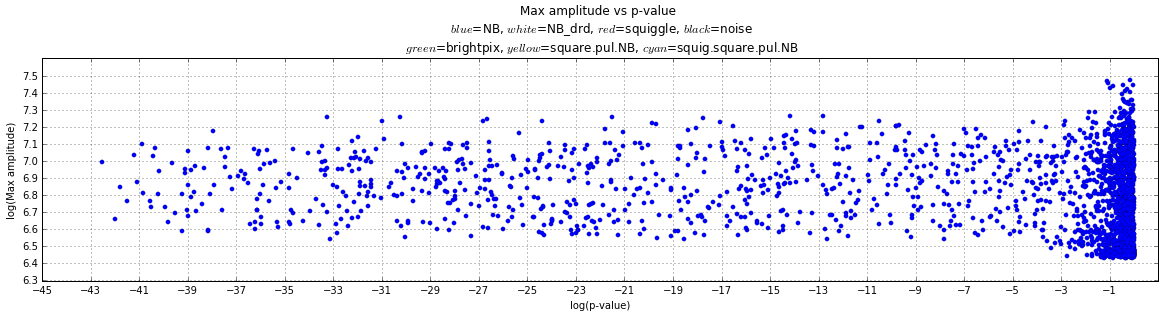

In [45]:
# p-value for a linear fit is useless: even NB p-value is spread all over!!
#plt.figure(figsize=(20,4))
fig = plt.figure(figsize=(20,4))
ax = fig.gca()
ax.set_xticks(np.arange(-45, 1, 2))
ax.set_yticks(np.arange(6.2, 7.6, 0.1))
plt.grid()
plt.scatter(np.log10(P_Val), np.log10(Max_Amp),linewidth='0.1')
plt.title('Max amplitude vs p-value \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(p-value)')
plt.ylabel('log(Max amplitude)')
plt.xlim([-45,1])
plt.show()

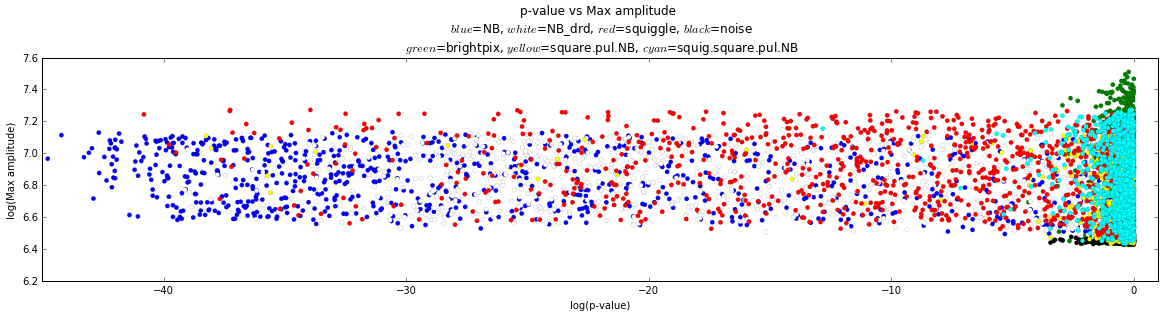

In [41]:
# p-value for a linear fit is useless: even NB p-value is spread all over!!

plt.figure(figsize=(20,4))
plt.scatter(np.log10(P_Val), np.log10(Max_Amp),c=color,linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(p-value)')
plt.ylabel('log(Max amplitude)')
plt.xlim([-45,1])
plt.show()

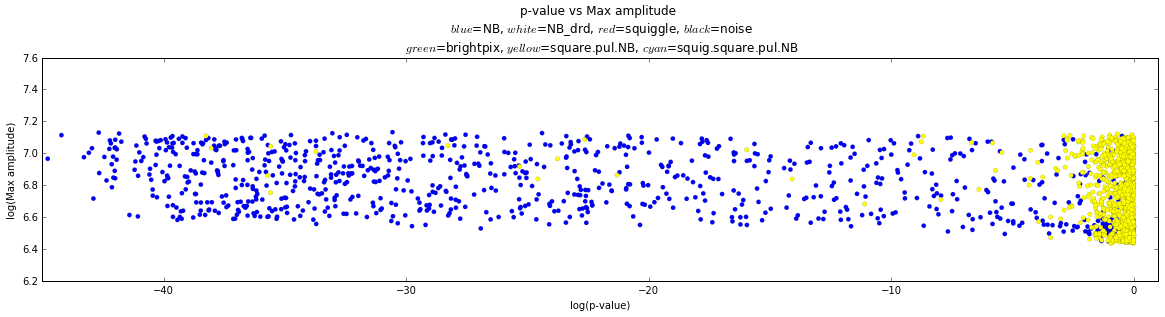

In [127]:
Signal_index1 = np.concatenate((NB_index, SqPulNB_index))
#NBdrd_index, Noise_index, SquigglePulNB_index, BP_index, Squiggle_index

plt.figure(figsize=(20,4))
plt.scatter(np.log10(list(np.array(P_Val)[Signal_index1])), np.log10(list(np.array(Max_Amp)[Signal_index1])),c=list(np.array(color)[Signal_index1]),linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(p-value)')
plt.ylabel('log(Max amplitude)')
plt.xlim([-45,1])
plt.ylim([6.2,7.6])
plt.show()

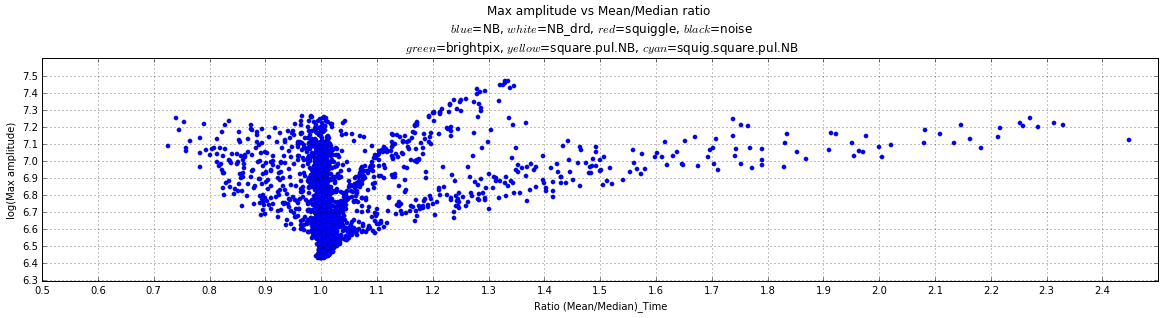

In [36]:
#plt.figure(figsize=(20,4))
fig = plt.figure(figsize=(20,4))
ax = fig.gca()
ax.set_xticks(np.arange(0.5, 2.5, 0.1))
ax.set_yticks(np.arange(6.2, 7.6, 0.1))
plt.grid()
plt.scatter(Ratio_Time, np.log10(Max_Amp),linewidth='0.1')
plt.title('Max amplitude vs Mean/Median ratio \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Ratio (Mean/Median)_Time')
plt.ylabel('log(Max amplitude)')
plt.xlim([0.5,2.5])
plt.show()

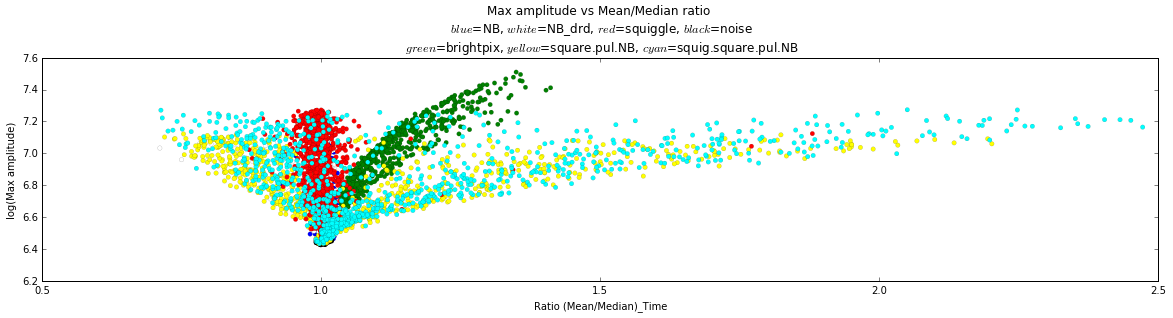

In [311]:
plt.figure(figsize=(20,4))
plt.scatter(Ratio_Time, np.log10(Max_Amp),c=color,linewidth='0.1')
plt.title('Max amplitude vs Mean/Median ratio \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Ratio (Mean/Median)_Time')
plt.ylabel('log(Max amplitude)')
plt.xlim([0.5,2.5])
plt.show()

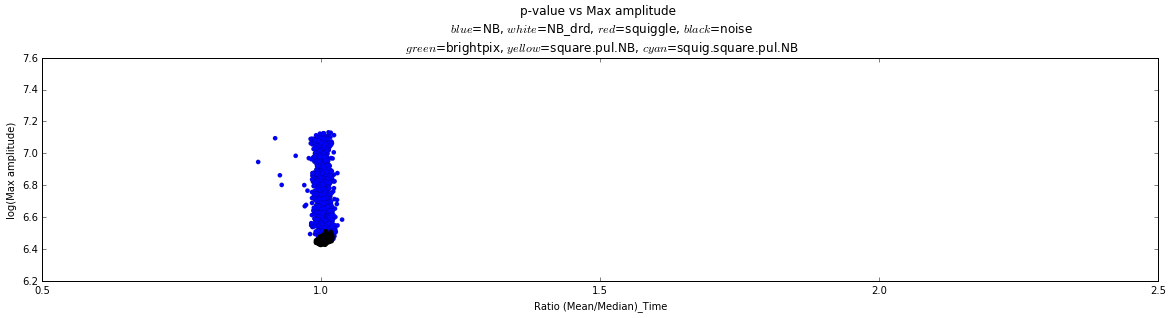

In [303]:
Signal_index2 = np.concatenate((NB_index, Noise_index))
#, SqPulNB_index, SquigglePulNB_index, BP_index, Squiggle_index, NBdrd_index

plt.figure(figsize=(20,4))
plt.scatter(list(np.array(Ratio_Time)[Signal_index2]), np.log10(list(np.array(Max_Amp)[Signal_index2])),c=list(np.array(color)[Signal_index2]),linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Ratio (Mean/Median)_Time')
plt.ylabel('log(Max amplitude)')
plt.xlim([0.5,2.5])
plt.ylim([6.2,7.6])
plt.show()

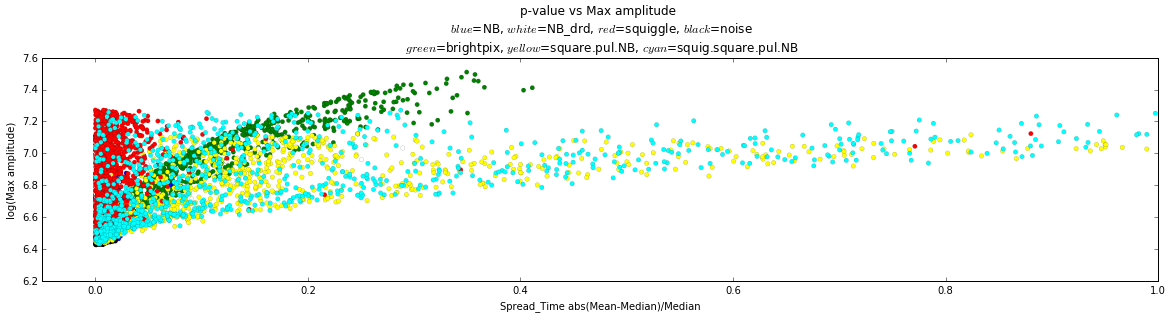

In [46]:
# Not very useful. Just folds the Ratio along vertical axis
plt.figure(figsize=(20,4))
plt.scatter(Spread_Time, np.log10(Max_Amp),c=color,linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Spread_Time abs(Mean-Median)/Median')
plt.ylabel('log(Max amplitude)')
plt.xlim([-0.05,1.0])
plt.show()

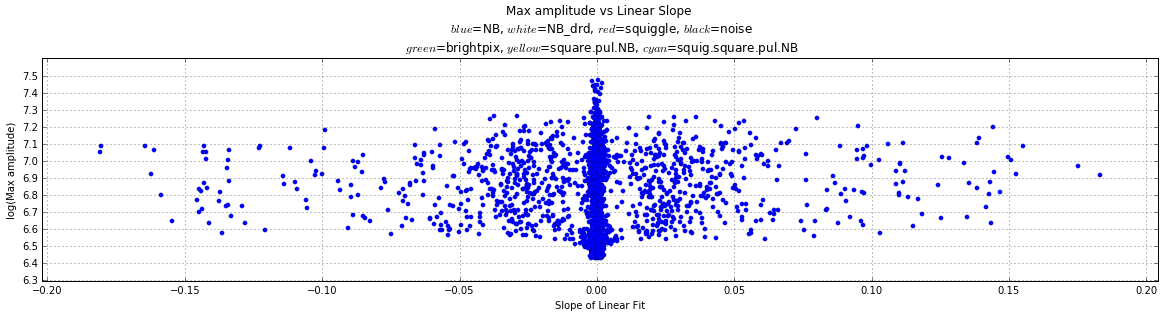

In [35]:
#plt.figure(figsize=(20,4))
fig = plt.figure(figsize=(20,4))
ax = fig.gca()
ax.set_xticks(np.arange(-0.3, 0.3, 0.05))
ax.set_yticks(np.arange(6.2, 7.6, 0.1))
plt.grid()
plt.scatter(Slope, np.log10(Max_Amp),linewidth='0.1')
plt.title('Max amplitude vs Linear Slope \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Slope of Linear Fit')
plt.ylabel('log(Max amplitude)')
#plt.xlim([0.5,2.5])
plt.show()

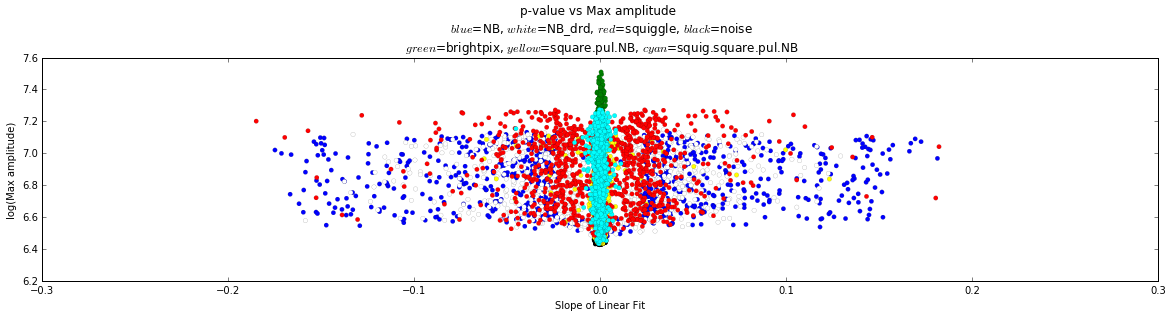

In [47]:
plt.figure(figsize=(20,4))
plt.scatter(Slope, np.log10(Max_Amp),c=color,linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Slope of Linear Fit')
plt.ylabel('log(Max amplitude)')
#plt.xlim([0.5,2.5])
plt.show()

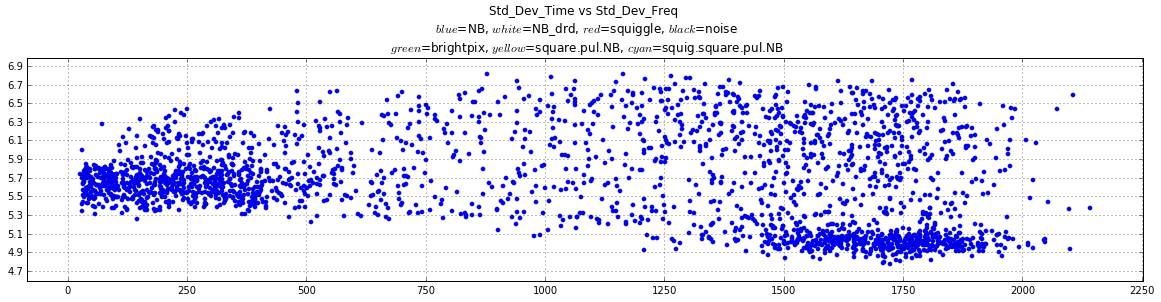

In [104]:
#plt.figure(figsize=(20,4))
fig = plt.figure(figsize=(20,4))
ax = fig.gca()
ax.set_xticks(np.arange(0, 2500, 250))
ax.set_yticks(np.arange(4.5, 7.0, 0.2))
plt.grid()
plt.scatter(Std_Dev_Freq, np.log10(Std_Dev_Time),linewidth='0.1')
plt.title('Std_Dev_Time vs Std_Dev_Freq \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
#plt.xlabel('Slope of Linear Fit')
#plt.ylabel('log(Max amplitude)')
#plt.xlim([1250,2500])
#plt.ylim([4.6,5.3])
plt.show()

In [102]:
Noise_results = [uuid[i] for i in range(len(results)) if np.log10(Std_Dev_Time[i])<5.2 and Std_Dev_Freq[i]>1370 and np.log10(Max_Amp[i])<6.5]
print('Guess Noise#=',len(Noise_results))
print(Noise_results[100])

('Guess Noise#=', 514)
10d8c6789b9e37c23b96e0caedc6d1bf


In [50]:
# Write DSP parameter values to text file
f_noise = open('preview_noise.txt', 'w')
for item in Noise_results:
  f_noise.write("%s\n" % item)
f_noise.close()

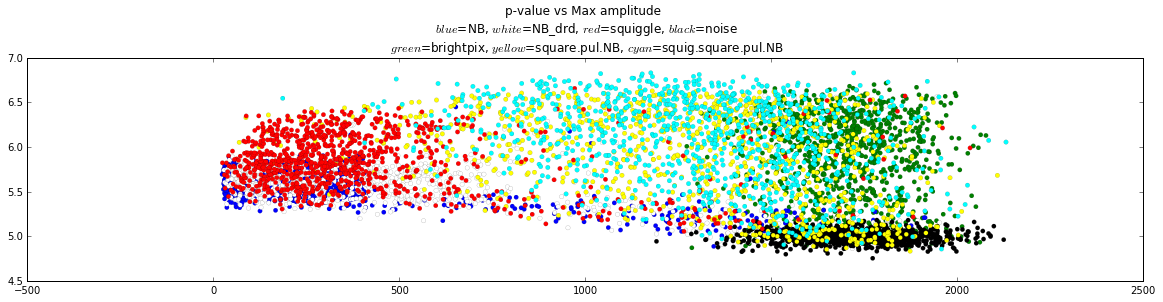

In [304]:
plt.figure(figsize=(20,4))
plt.scatter(Std_Dev_Freq, np.log10(Std_Dev_Time),c=color,linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
#plt.xlabel('Slope of Linear Fit')
#plt.ylabel('log(Max amplitude)')
#plt.xlim([0.5,2.5])
plt.show()

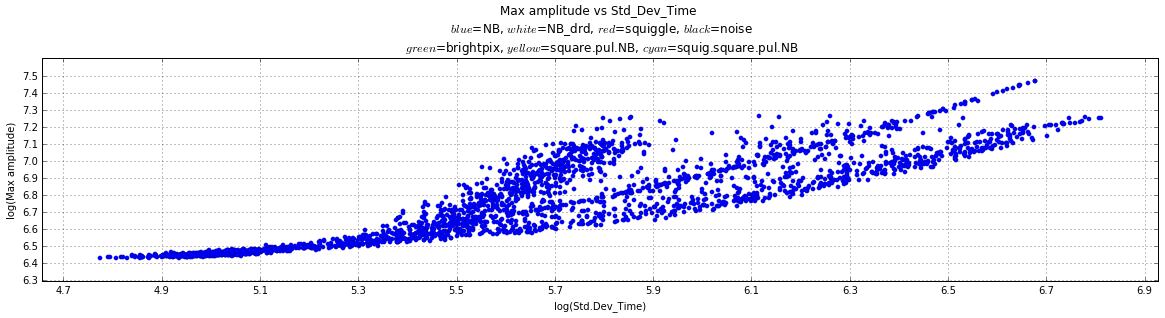

In [40]:
#plt.figure(figsize=(20,4))
fig = plt.figure(figsize=(20,4))
ax = fig.gca()
ax.set_xticks(np.arange(4.5, 7.0, 0.2))
ax.set_yticks(np.arange(6.2, 7.6, 0.1))
plt.grid()
plt.scatter(np.log10(Std_Dev_Time), np.log10(Max_Amp),linewidth='0.1')
plt.title('Max amplitude vs Std_Dev_Time \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(Std.Dev_Time)')
plt.ylabel('log(Max amplitude)')
#plt.xlim([0.5,2.5])
plt.show()

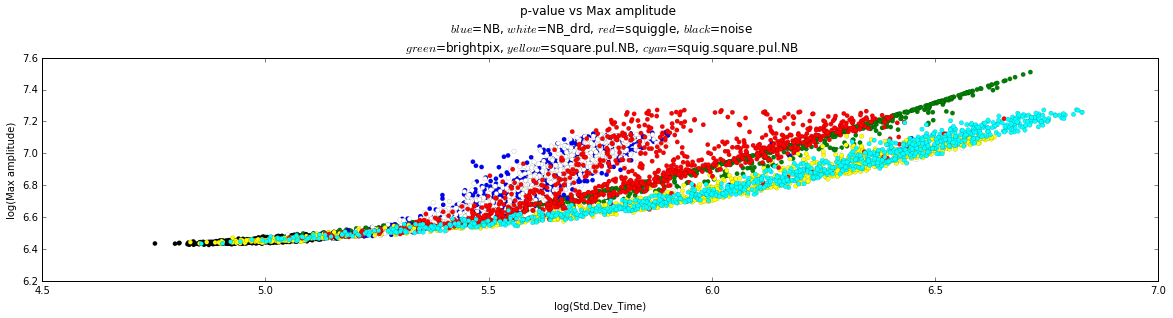

In [48]:
plt.figure(figsize=(20,4))
plt.scatter(np.log10(Std_Dev_Time), np.log10(Max_Amp),c=color,linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(Std.Dev_Time)')
plt.ylabel('log(Max amplitude)')
#plt.xlim([0.5,2.5])
plt.show()

In [57]:
plt.figure(figsize=(20,4))
plt.scatter(AboveCnt_Time, np.log10(Max_Amp),c=color,linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('# of MaxAmps above (median+std.dev)')
plt.ylabel('log(Max amplitude)')
#plt.xlim([-45,1])
plt.show()

NameError: name 'color' is not defined

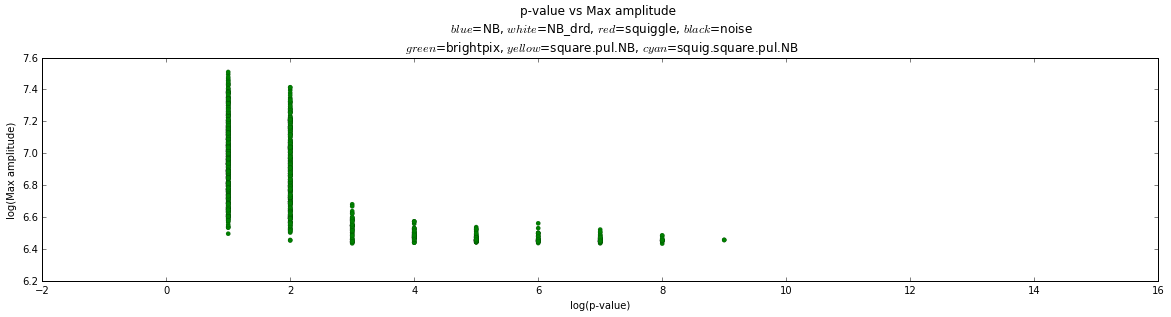

In [189]:
Signal_index3 = np.concatenate((BP_index,[0]))
#NBdrd_index, SquigglePulNB_index, Squiggle_index, SqPulNB_index, Noise_index, NB_index

plt.figure(figsize=(20,4))
plt.scatter(list(np.array(AboveCnt_Time)[Signal_index3]), np.log10(list(np.array(Max_Amp)[Signal_index3])),c=list(np.array(color)[Signal_index3]),linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(p-value)')
plt.ylabel('log(Max amplitude)')
plt.xlim([-2,16])
plt.ylim([6.2,7.6])
plt.show()

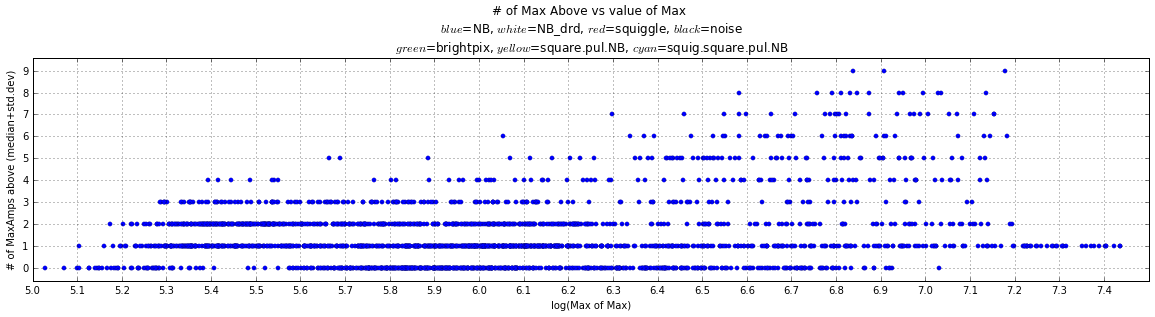

In [58]:
#plt.figure(figsize=(20,4))
fig = plt.figure(figsize=(20,4))
ax = fig.gca()
ax.set_xticks(np.arange(5.0, 7.5, 0.1))
ax.set_yticks(np.arange(-2, 12, 1))
plt.grid()
plt.scatter(np.log10(AboveMax_Time), AboveCnt_Time,linewidth='0.1')
plt.title('# of Max Above vs value of Max \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(Max of Max)')
plt.ylabel('# of MaxAmps above (median+std.dev)')
plt.xlim([5,7.5])
plt.show()

In [59]:
BP_results = [uuid[i] for i in range(len(results)) if AboveCnt_Time[i]>0 and AboveCnt_Time[i]<3 and np.log10(AboveMax_Time[i])>5.7]
print('Guess BP#=',len(BP_results))
print(BP_results[100])

('Guess BP#=', 895)
4c860e9d24fb961039fcdfe2a8c08600


In [60]:
# Write DSP parameter values to text file
f_bp = open('preview_bp.txt', 'w')
for item in BP_results:
  f_bp.write("%s\n" % item)
f_bp.close()

/usr/local/src/bluemix_jupyter_bundle.v54/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


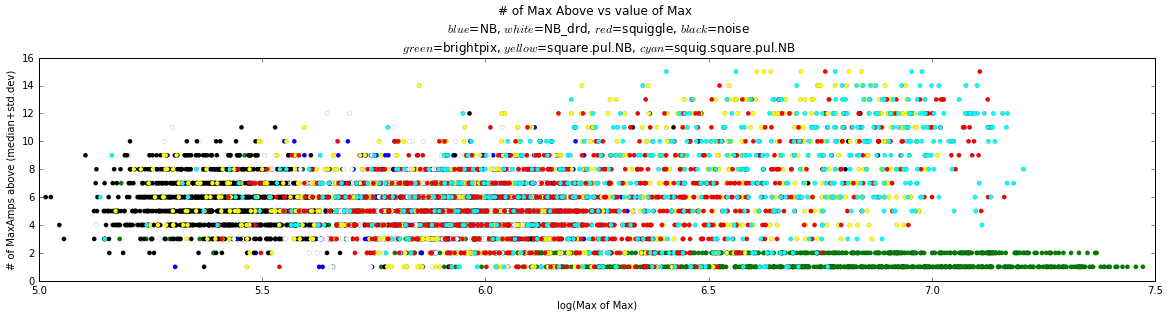

In [207]:
plt.figure(figsize=(20,4))
plt.scatter(np.log10(AboveMax_Time), AboveCnt_Time,c=color,linewidth='0.1')
plt.title('# of Max Above vs value of Max \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(Max of Max)')
plt.ylabel('# of MaxAmps above (median+std.dev)')
plt.xlim([5,7.5])
plt.show()

/usr/local/src/bluemix_jupyter_bundle.v54/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


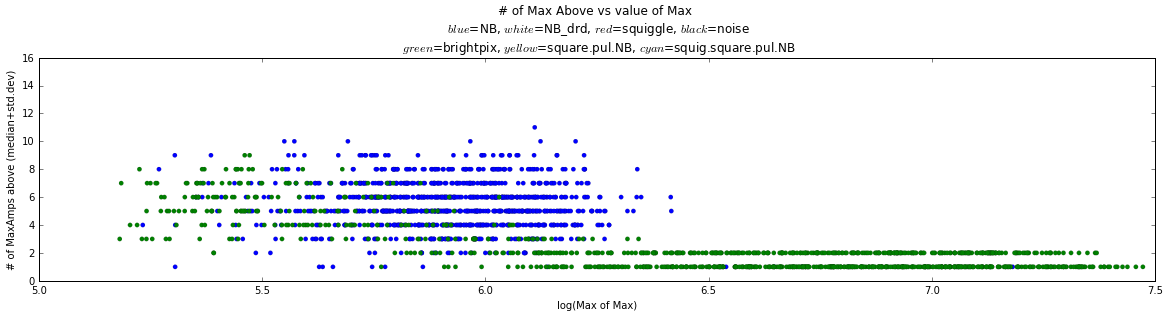

In [210]:
Signal_index3 = np.concatenate((NB_index,BP_index))
#NBdrd_index, SquigglePulNB_index, Squiggle_index, SqPulNB_index, Noise_index, [0]

plt.figure(figsize=(20,4))
plt.scatter(np.log10(list(np.array(AboveMax_Time)[Signal_index3])), list(np.array(AboveCnt_Time)[Signal_index3]),c=list(np.array(color)[Signal_index3]),linewidth='0.1')
plt.title('# of Max Above vs value of Max \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(Max of Max)')
plt.ylabel('# of MaxAmps above (median+std.dev)')
plt.ylim([0,16])
plt.xlim([5,7.5])
plt.show()

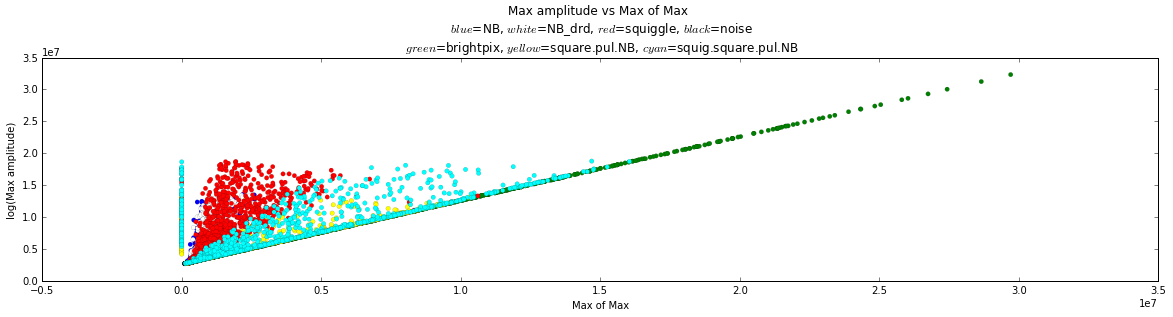

In [233]:
plt.figure(figsize=(20,4))
plt.scatter(AboveMax_Time, Max_Amp,c=color,linewidth='0.1')
plt.title('Max amplitude vs Max of Max \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Max of Max')
plt.ylabel('log(Max amplitude)')
#plt.xlim([-45,1])
plt.show()

NameError: name 'color' is not defined

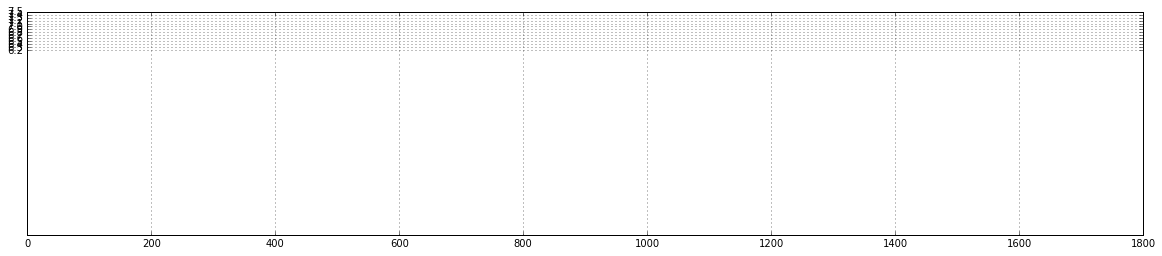

In [41]:
#plt.figure(figsize=(20,4))
fig = plt.figure(figsize=(20,4))
ax = fig.gca()
ax.set_xticks(np.arange(0, 2000, 200))
ax.set_yticks(np.arange(6.2, 7.6, 0.1))
plt.grid()
plt.scatter(Std_Dev_Freq, np.log10(Max_Amp),c=color,linewidth='0.1')
plt.title('Max amplitude vs Std Dev along Freq \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Std Dev along Freq')
plt.ylabel('log(Max amplitude)')
plt.xlim([0,2000])
plt.show()

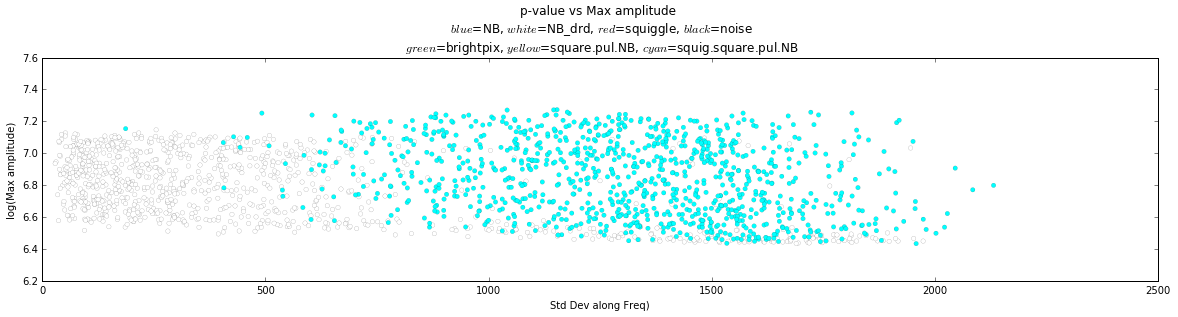

In [300]:
Signal_index6 = np.concatenate((NBdrd_index, SquigglePulNB_index))
# Noise_index,BP_index, NB_index,, SqPulNB_index, Squiggle_index [0]

plt.figure(figsize=(20,4))
plt.scatter(list(np.array(Std_Dev_Freq)[Signal_index6]), np.log10(list(np.array(Max_Amp)[Signal_index6])),c=list(np.array(color)[Signal_index6]),linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Std Dev along Freq)')
plt.ylabel('log(Max amplitude)')
plt.xlim([0,2500])
plt.ylim([6.2,7.6])
plt.show()

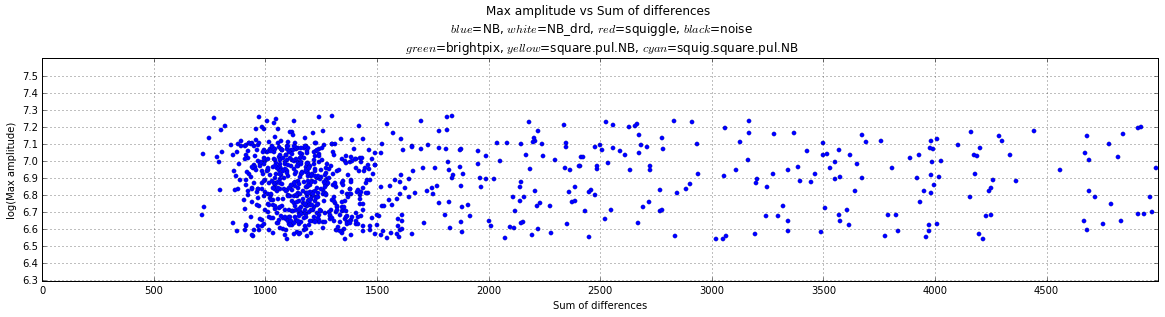

In [62]:
#plt.figure(figsize=(20,4))
fig = plt.figure(figsize=(20,4))
ax = fig.gca()
ax.set_xticks(np.arange(0, 5000, 500))
ax.set_yticks(np.arange(6.2, 7.6, 0.1))
plt.grid()
plt.scatter(Sum_Diff, np.log10(Max_Amp),linewidth='0.1')
plt.title('Max amplitude vs Sum of differences \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Sum of differences')
plt.ylabel('log(Max amplitude)')
plt.xlim([0,5000])
plt.show()

In [63]:
NB_results = [uuid[i] for i in range(len(results)) if Sum_Diff[i]<1400 and np.log10(Max_Amp[i])<7.1]
print('Guess NB#=',len(NB_results))
print(NB_results[100])

('Guess NB#=', 493)
8bb37930159f1bca8bee8f5535d9048c


In [64]:
# Write DSP parameter values to text file
f_nb = open('preview_nb.txt', 'w')
for item in NB_results:
  f_nb.write("%s\n" % item)
f_nb.close()

In [110]:
NBdrd_results = [uuid[i] for i in range(len(results)) if Sum_Diff[i]<1400 and np.log10(Max_Amp[i])<7.1]
print('Guess NBdrd#=',len(NBdrd_results))
print(NBdrd_results[100])

('Guess NBdrd#=', 493)
8bb37930159f1bca8bee8f5535d9048c


In [111]:
# Write DSP parameter values to text file
f_nbdrd = open('preview_nbdrd.txt', 'w')
for item in NBdrd_results:
  f_nbdrd.write("%s\n" % item)
f_nbdrd.close()

In [107]:
SqPulNB_results = [uuid[i] for i in range(len(results)) if Sum_Diff[i]>10000 and Sum_Diff[i]<50000 and np.log10(Max_Amp[i])>6.5]
print('Guess SqPulNB#=',len(SqPulNB_results))
print(SqPulNB_results[100])

('Guess SqPulNB#=', 585)
0fff3f9d3ae9c0b6dd51f14875e89c75


In [108]:
# Write DSP parameter values to text file
f_SqPulnb = open('preview_SqPulnb.txt', 'w')
for item in SqPulNB_results:
  f_SqPulnb.write("%s\n" % item)
f_SqPulnb.close()

In [113]:
SqgSqPulNB_results = [uuid[i] for i in range(len(results)) if Sum_Diff[i]>10000 and Sum_Diff[i]<50000 and np.log10(Max_Amp[i])>6.5]
print('Guess SqgSqPulNB#=',len(SqgSqPulNB_results))
print(SqgSqPulNB_results[100])

('Guess SqgSqPulNB#=', 585)
0fff3f9d3ae9c0b6dd51f14875e89c75


In [114]:
# Write DSP parameter values to text file
f_SqgSqPulnb = open('preview_SqgSqPulnb.txt', 'w')
for item in SqgSqPulNB_results:
  f_SqgSqPulnb.write("%s\n" % item)
f_SqgSqPulnb.close()

In [117]:
Sqg_results = [uuid[i] for i in range(len(results)) if (Sum_Diff[i]>1500 and Sum_Diff[i]<5000 and np.log10(Max_Amp[i])>6.6)or(Sum_Diff[i]>1500 and np.log10(Max_Amp[i])>7.1)]
print('Guess Sqg#=',len(Sqg_results))
print(Sqg_results[100])

('Guess Sqg#=', 402)
e4ef63d2c7a7bb712fa59fbcc0178b36


In [118]:
# Write DSP parameter values to text file
f_Sqg = open('preview_Sqg.txt', 'w')
for item in Sqg_results:
  f_Sqg.write("%s\n" % item)
f_Sqg.close()

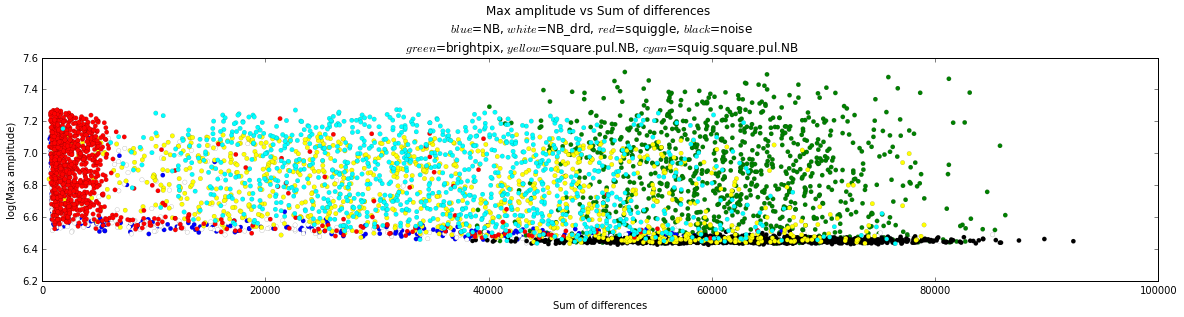

In [281]:
plt.figure(figsize=(20,4))
plt.scatter(Sum_Diff, np.log10(Max_Amp),c=color,linewidth='0.1')
plt.title('Max amplitude vs Sum of differences \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Sum of differences')
plt.ylabel('log(Max amplitude)')
plt.xlim([0,100000])
plt.show()

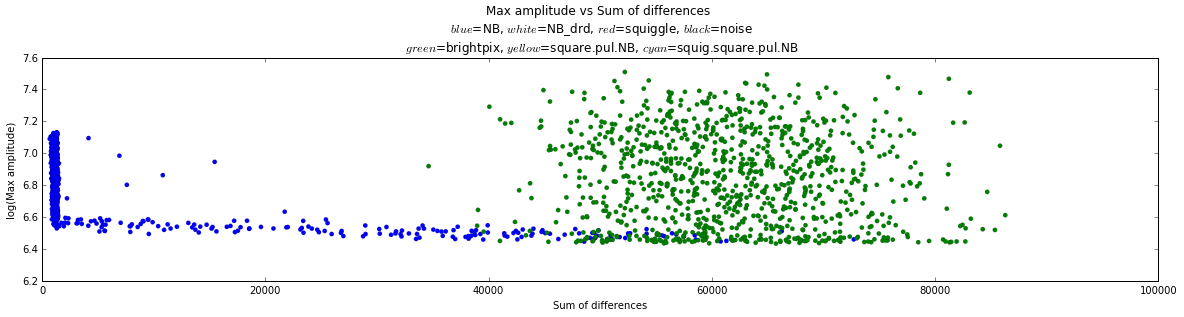

In [282]:
Signal_index6 = np.concatenate((NB_index,BP_index))
# Noise_index, NBdrd_index,SquigglePulNB_index, SqPulNB_index, Squiggle_index  [0]

plt.figure(figsize=(20,4))
plt.scatter(list(np.array(Sum_Diff)[Signal_index6]), np.log10(list(np.array(Max_Amp)[Signal_index6])),c=list(np.array(color)[Signal_index6]),linewidth='0.1')
plt.title('Max amplitude vs Sum of differences \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('Sum of differences')
plt.ylabel('log(Max amplitude)')
plt.xlim([0,100000])
plt.ylim([6.2,7.6])
plt.show()

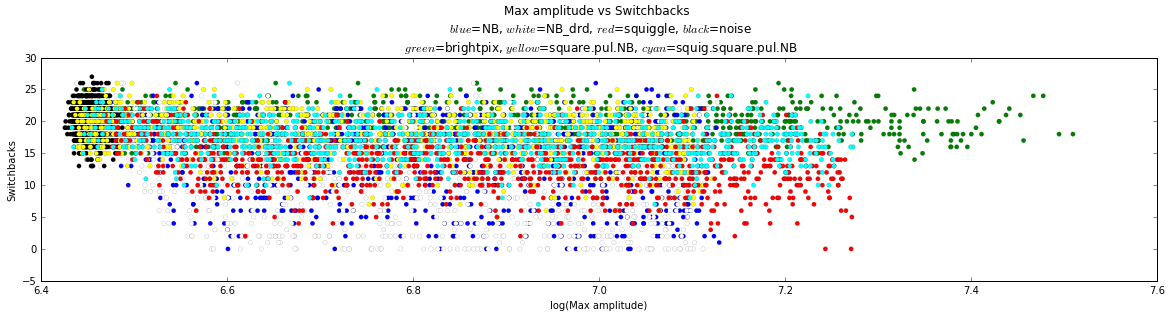

In [292]:
plt.figure(figsize=(20,4))
plt.scatter(np.log10(Max_Amp), Switchbacks, c=color,linewidth='0.1')
plt.title('Max amplitude vs Switchbacks \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(Max amplitude)')
plt.ylabel('Switchbacks')
plt.xlim([6.4,7.6])
plt.show()

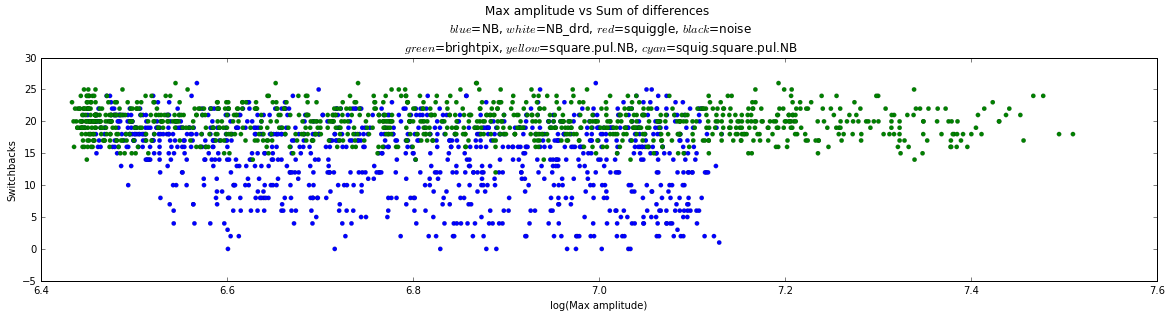

In [293]:
Signal_index6 = np.concatenate((NB_index,BP_index))
# Noise_index, NBdrd_index,SquigglePulNB_index, SqPulNB_index, Squiggle_index  [0]

plt.figure(figsize=(20,4))
plt.scatter(np.log10(list(np.array(Max_Amp)[Signal_index6])), list(np.array(Switchbacks)[Signal_index6]), c=list(np.array(color)[Signal_index6]),linewidth='0.1')
plt.title('Max amplitude vs Sum of differences \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
plt.xlabel('log(Max amplitude)')
plt.ylabel('Switchbacks')
plt.xlim([6.4,7.6])
plt.show()

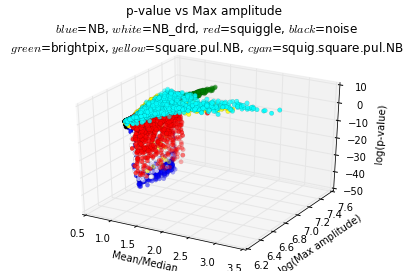

In [126]:
# Remove that one outlier and plot color as per signal type
fig = plt.figure()#(figsize=(10,10))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection='3d')
ax.scatter(Ratio_Time, np.log10(Max_Amp),np.log10(P_Val),c=color,linewidth='0.1')
plt.title('p-value vs Max amplitude \n $blue$=NB, $white$=NB_drd, $red$=squiggle, $black$=noise \n $green$=brightpix, $yellow$=square.pul.NB, $cyan$=squig.square.pul.NB')
ax.set_xlabel('Mean/Median')
ax.set_ylabel('log(Max amplitude)')
ax.set_zlabel('log(p-value)')
#plt.xlim([0.5,2.5])
#ax.view_init(4, -72)
#plt.axis('off')
plt.show()


In [16]:
# Separate signals based on low max-amplitude (noise)
LowAmp = [Class[i] for i in range(len(results)) if np.log10(Max_Amp[i])<7.5]
Noise_results = [uuid[i] for i in range(len(results)) if np.log10(Max_Amp[i])<7.5]
print('Guess Noise#=',len(LowAmp))
cnt=0
for i in range(len(LowAmp)): # check the number of 'noise' classified signals in the cluster classified as 'noise'
    if LowAmp[i]=='noise':
        cnt+=1
print('Actual Noise#=',cnt)

('Guess Noise#=', 989)
('Actual Noise#=', 989)


In [17]:
# Separate signals based on high p-value and high max-amplitude, meaning near perfect straight line (narrow band (NB))
# with high SNR
HighP = [Class[i] for i in range(len(results)) if np.log10(P_Val[i])<-45 and np.log10(Max_Amp[i])>7.5]
NB_results = [uuid[i] for i in range(len(results)) if np.log10(P_Val[i])<-45 and np.log10(Max_Amp[i])>7.5]
print('Guess NB#=',len(HighP))
cnt=0
for i in range(len(HighP)):
    if HighP[i]=='narrowband': # check the number of 'NB' classified signals in the cluster classified as 'NB'
        cnt+=1
print('Actual NB#=',cnt)

('Guess NB#=', 939)
('Actual NB#=', 939)


In [18]:
# Separate signals based on mid-range p-value and high max-amplitude, meaning curved line (dynamic drift signals (drd))
MidP = [Class[i] for i in range(len(results)) if np.log10(P_Val[i])>-45 and np.log10(P_Val[i])<-15 and np.log10(Max_Amp[i])>7.5]
drd_results = [uuid[i] for i in range(len(results)) if np.log10(P_Val[i])>-45 and np.log10(P_Val[i])<-15 and np.log10(Max_Amp[i])>7.5]
print('Guess drd#=',len(MidP))
cnt=0
for i in range(len(MidP)):
    if MidP[i]=='narrowbanddrd': # check the number of 'drd' classified signals in the cluster classified as 'drd'
        cnt+=1
print('Actual drd#=',cnt)

('Guess drd#=', 926)
('Actual drd#=', 829)


In [19]:
# Separate signals based on low p-value and high max-amplitude, meaning wavy line (squiggle)
LowP = [Class[i] for i in range(len(results)) if np.log10(P_Val[i])>-15 and np.log10(Max_Amp[i])>7.5]
suiggle_results = [uuid[i] for i in range(len(results)) if np.log10(P_Val[i])>-15 and np.log10(Max_Amp[i])>7.5]
print('Guess squiggle#=',len(LowP))
cnt=0
for i in range(len(LowP)):
    if LowP[i]=='squiggle': # check the number of 'squiggle' classified signals in the cluster classified as 'squiggle'
        cnt+=1
print('Actual squiggle#=',cnt)

('Guess squiggle#=', 1146)
('Actual squiggle#=', 946)


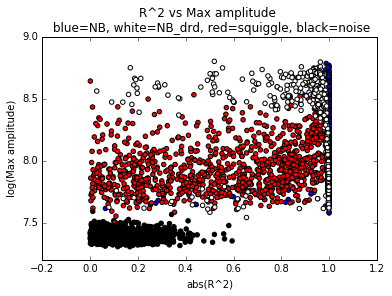

In [45]:
# Plot all data in various combinations of parameters to get a 2D plot where one can identify clusters
#plt.scatter(map(abs, R_Val), map(log, Max_Amp))
plt.scatter(map(abs, R_Val), np.log10(Max_Amp),c=color)
plt.title('R^2 vs Max amplitude \n blue=NB, white=NB_drd, red=squiggle, black=noise')
plt.xlabel('abs(R^2)')
plt.ylabel('log(Max amplitude)')
plt.show()

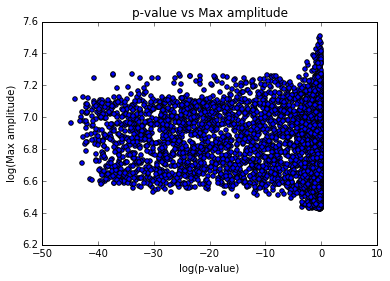

In [47]:
# Plot all data in various combinations of parameters to get a 2D plot where one can identify clusters
#plt.scatter(map(abs, R_Val), map(log, Max_Amp))
plt.scatter(np.log10(P_Val), np.log10(Max_Amp))
plt.title('p-value vs Max amplitude')
plt.xlabel('log(p-value)')
plt.ylabel('log(Max amplitude)')
#plt.xlim([-160,10])
plt.show()

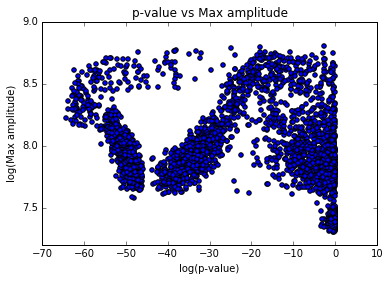

In [22]:
# Remove that one outlier
#plt.scatter(map(abs, R_Val), map(log, Max_Amp))
plt.scatter(np.log10(P_Val), np.log10(Max_Amp))
plt.title('p-value vs Max amplitude')
plt.xlabel('log(p-value)')
plt.ylabel('log(Max amplitude)')
plt.xlim([-70,10])
plt.show()

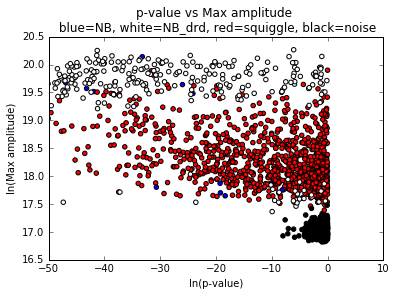

In [46]:
# Plot all data in various combinations of parameters to get a 2D plot where one can identify clusters
#plt.scatter(map(abs, R_Val), map(log, Max_Amp))
plt.scatter(np.log(P_Val), np.log(Max_Amp),c=color)
plt.title('p-value vs Max amplitude \n blue=NB, white=NB_drd, red=squiggle, black=noise')
plt.xlabel('ln(p-value)')
plt.ylabel('ln(Max amplitude)')
plt.xlim([-50,10])
plt.show()

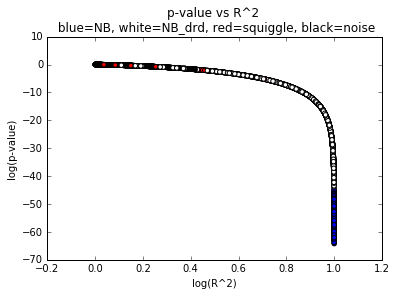

In [47]:
# Plot all data in various combinations of parameters to get a 2D plot where one can identify clusters
plt.scatter(map(abs, R_Val), np.log10(P_Val),c=color)
plt.title('p-value vs R^2 \n blue=NB, white=NB_drd, red=squiggle, black=noise')
plt.xlabel('log(R^2)')
plt.ylabel('log(p-value)')
plt.ylim([-70,10])
#plt.xlim([0.998,1.001])
plt.show()

In [45]:
#!ls -al "$mydatafolder"/png

In [ ]:
# DID NOT USE THE FOLLOWING CODE FOR MY MANUAL CLUSTERING METHOD

# Create Training / Test sets

Using the `basic` list, we'll create training and test sets for each signal class. Then we'll archive the `.png` files into a handful of `.zip` files (We need the .zip files to be smaller than 25 MB each because there is a limitation with the size of batches of data that are uploaded to Watson Visual Recognition when training a classifier (200 MB total).)

In [17]:
# Grab the Basic file list in order to 
# Organize the Data into classes

indexfile_rows = open(workingIndexFile).readlines()
                                                    
uuids_classes_as_list = indexfile_rows  [1:]#slice off the first line (header)

def row_to_json(row):
    uuid,sigclass = row.strip('\n').split(',')  #strip \n and split uuid, class
    return {'uuid':uuid, 'signal_classification':sigclass}

uuids_classes_as_list = map(lambda row: row_to_json(row), uuids_classes_as_list)
print "found {} files".format(len(uuids_classes_as_list))

uuids_group_by_class = {}
for item in uuids_classes_as_list:
    uuids_group_by_class.setdefault(item['signal_classification'], []).append(item)

found 4000 files


In [18]:

#At first, use just 20 percent and 10 percent. This will be useful 
#as you prototype. You'll you use these to train Watson in the next notebook
#So, if we only do the first 20 percent and 10 percent, we can move through
#the tutorial quickly at first. Then you can come back here and increase these
#percentages. 
training_percentage = 0.20
test_percentage = 0.10

assert training_percentage + test_percentage <= 1.0

training_set_group_by_class = {}
test_set_group_by_class = {}
for k, v in uuids_group_by_class.iteritems():
    
    total = len(v)
    training_size = int(total * training_percentage)
    test_size = int(total * test_percentage)
    
    training_set = v[:training_size]
    test_set = v[-1*test_size:]
    
    training_set_group_by_class[k] = training_set
    test_set_group_by_class[k] = test_set
    
    print '{}: training set size: {}'.format(k, len(training_set))
    print '{}: test set size: {}'.format(k, len(test_set))

squiggle: training set size: 200
squiggle: test set size: 100
narrowband: training set size: 200
narrowband: test set size: 100
noise: training set size: 200
noise: test set size: 100
narrowbanddrd: training set size: 200
narrowbanddrd: test set size: 100


In [20]:
training_set_group_by_class['noise'][10]

{'signal_classification': 'noise',
 'uuid': 'c9d07d45-f425-4be2-9751-1274aecec25f'}

In [21]:
fnames = [ os.path.join(outputpng_folder, vv['uuid'] + '.dat.png') for vv in v]

In [22]:
#make sure this looks right.
print fnames[0]
os.stat(fnames[0]).st_size

/gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/png/beb79586-3e6c-40e2-93a2-4c1de157ff5c.dat.png


189229

In [23]:
zipfilefolder = mydatafolder + '/zipfiles'
if os.path.exists(zipfilefolder) is False:
    os.makedirs(zipfilefolder)

In [24]:
max_zip_file_size_in_mb = 25

In [25]:
#Create the Zip files containing the training PNG files
#Note that this limits output files to be less than <max_zip_file_size_in_mb> MB because WatsonVR has a limit on the 
#size of input files that can be sent in single HTTP calls to train a custom classifier

for k, v, in training_set_group_by_class.iteritems():
    
    fnames = [ os.path.join(outputpng_folder, vv['uuid'] + '.dat.png') for vv in v]  #yes, files are <uuid>.dat.png :/
    
    count = 1
    for fn in fnames:
        
        archive_name = '{}/classification_{}_{}.zip'.format(zipfilefolder, count, k)
        
        if os.path.exists(archive_name):
            zz = zipfile.ZipFile(archive_name, mode='a')
        else:
            print 'creating new archive', archive_name
            zz = zipfile.ZipFile(archive_name, mode='w')
           
        
        zz.write(fn, fn.split('/')[-1])
        zz.close()
        
        #if archive_name folder exceeds <max_zip_file_size_in_mb> MB, increase count to create a new one
        if os.path.getsize(archive_name) > max_zip_file_size_in_mb * 1024 ** 2:
            count += 1
            

creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_1_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_2_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_1_narrowband.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_2_narrowband.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_1_noise.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_2_noise.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_1_narrowbanddrd.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/w

In [26]:
# Create the Zip files containing the test PNG files using the following naming convention:
# testset_<NUMBER>_<CLASS>.zip (step 4 will break if a different naming convention is used)
# Refer to https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/#classify_an_image for ZIP size and content limitations:
# "The max number of images in a .zip file is limited to 20, and limited to 5 MB."

for k, v, in test_set_group_by_class.iteritems():
    
    fnames = [outputpng_folder + '/' + vv['uuid'] + '.dat.png' for vv in v]  #yes, files are <uuid>.dat.png :/
    
    # archive counter
    count = 1
    # number of image files in archive counter
    image_count = 0
    for fn in fnames:
        
        archive_name = '{}/testset_{}_{}.zip'.format(zipfilefolder, count, k)
        
        if os.path.exists(archive_name):
            if os.path.getsize(archive_name) + os.path.getsize(fn) >= 4.9 * 1024 ** 2:
                # current ZIP archive size + size of this file > max size (or at least close to); create new archive
                count += 1
                image_count = 0
                archive_name = '{}/testset_{}_{}.zip'.format(zipfilefolder, count, k)
                print 'creating new archive', archive_name
                zz = zipfile.ZipFile(archive_name, mode='w')
            else:
                zz = zipfile.ZipFile(archive_name, mode='a')
        else:
            print 'creating new archive', archive_name
            zz = zipfile.ZipFile(archive_name, mode='w')
           
        zz.write(fn)
        zz.close()
        
        image_count += 1
        # the number of files > max number of files supported by API; create new archive
        if image_count > 19:
            count +=1
            image_count = 0

creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_1_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_2_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_3_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_4_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_5_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_1_narrowband.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_2_narrowband.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_3_narrowband.zip
cr

In [27]:
!ls -alh "$mydatafolder"/zipfiles/

total 684M
drwx------ 2 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 4.0K Jun 10 18:16 .
drwx------ 5 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 4.0K Jun 10 18:15 ..
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  26M Jun 10 18:15 classification_1_narrowbanddrd.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  26M Jun 10 18:15 classification_1_narrowband.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  26M Jun 10 18:15 classification_1_noise.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  26M Jun 10 18:15 classification_1_squiggle.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  13M Jun 10 18:16 classification_2_narrowbanddrd.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  13M Jun 10 18:15 classification_2_narrowband.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  14M Jun 10 18:15 classification_2_noise.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  13M Jun 10 18:15 classification_2_squiggle.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77

# Exporting your Zip files

You do NOT need to do this if you're going on to the next notebook where you use Watson to classify your images from this Spark cluster. That notebook will read the data from here.

However, if you want to move these data elsewhere, teasiest and fastest way to push your data out is to send it to your IBM Object Storage

1. Log in to https://bluemix.net
2. Scroll down and find your Object Storage instance. 
  * If you do not have one, find the "Catalog" link and look for the Object Storage service to create a new instance (5 GB of free space)
3. Select the `Service Credentials` tab and `View Credentials`
4. Copy these into your notebook below.


In [ ]:
import swiftclient.client as swiftclient

credentials = {
  'auth_uri':'',
  'global_account_auth_uri':'',
  'username':'xx',
  'password':"xx",
  'auth_url':'https://identity.open.softlayer.com',
  'project':'xx',
  'projectId':'xx',
  'region':'dallas',
  'userId':'xx',
  'domain_id':'xx',
  'domain_name':'xx',
  'tenantId':'xx'
}

In [ ]:
conn_seti_data = swiftclient.Connection(
    key=creds_seti_public['password'],
    authurl=creds_seti_public['auth_url']+"/v3",
    auth_version='3',
    os_options={
        "project_id": creds_seti_public['projectId'],
        "user_id": creds_seti_public['userId'],
        "region_name": creds_seti_public['region']})

In [ ]:
myObjectStorageContainer = 'example_pngs'  
conn_seti_data.post_container(myObjectStorageContainer)  #creates a new container in your object storage

someFile = os.path.join(zipfilefolder, 'classification_1_narrowband.zip')

etag = conn_seti_data.put_object(myObjectStorageContainer, someFile, open(someFile,'rb').read())

In [430]:
!pip list --isolated

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
appdirs (1.4.3)
asn1crypto (0.22.0)
Babel (2.1.1)
backports-abc (0.4)
backports.shutil-get-terminal-size (1.0.0)
backports.ssl-match-hostname (3.4.0.2)
backports.weakref (1.0rc1)
basemap (1.0.7)
beautifulsoup4 (4.4.1)
biopython (1.66)
bitarray (0.8.1)
bleach (2.0.0)
bokeh (0.12.5)
boto3 (1.4.4)
botocore (1.5.50)
brunel (2.3)
cdsax-jupyter-extensions (0.1)
certifi (2017.7.27.1)
cffi (1.10.0)
chardet (3.0.4)
cognitive-assistant (1.0.30)
configparser (3.5.0)
cryptography (2.0.2)
cycler (0.9.0)
Cython (0.23.4)
debtcollector (1.1.0)
decorator (4.0.6)
descartes (1.0.1)
dill (0.2.5)
dlaas-client (0.1.29)
docutils (0.13.1)
entrypoints (0.2.2)
enum (0.4.6)
enum34 (1.1.6)
extension-utils (0.1.95)
extras (0.0.3)
fixtures (2.0.0)
Flask (0.10.1)
funcsigs (1.0.2)
functools32 (3.2.3.post2)
f

In [434]:
!pip install --user --upgrade python-keystoneclient
#!pip install --user --upgrade python-swiftclient

    100% |████████████████████████████████| 378kB 2.6MB/s eta 0:00:01
Requirement already up-to-date: requests>=2.14.2 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from python-keystoneclient)
Requirement already up-to-date: six>=1.9.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from python-keystoneclient)
    100% |████████████████████████████████| 102kB 7.7MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 7.5MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 2.6MB/s eta 0:00:01
    100% |████████████████████████████████| 276kB 3.6MB/s eta 0:00:01
    100% |████████████████████████████████| 112kB 7.4MB/s eta 0:00:01
Requirement already up-to-date: idna<2.6,>=2.5 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from requests>=2.14.2->python-keys

In [435]:
#!pip install --user --upgrade python-keystoneclient
!pip install --user --upgrade python-swiftclient

    100% |████████████████████████████████| 81kB 4.6MB/s ta 0:00:011
Requirement already up-to-date: requests>=1.1 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from python-swiftclient)
Requirement already up-to-date: six>=1.5.2 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from python-swiftclient)
Requirement already up-to-date: idna<2.6,>=2.5 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from requests>=1.1->python-swiftclient)
Requirement already up-to-date: urllib3<1.23,>=1.21.1 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from requests>=1.1->python-swiftclient)
Requirement already up-to-date: chardet<3.1.0,>=3.0.2 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.lo

In [161]:

# @hidden_cell
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_205c4f18_fee1_4d57_8b3d_a796f1125e04',
  'project_id':'aa22daa1070347848cbdd103df44dfbb',
  'region':'dallas',
  'user_id':'47404e1c8d8b46eeb84f45cff881bae0',
  'domain_id':'e15e35e73d58464389fbf14d81b52f20',
  'domain_name':'1318277',
  'username':'member_cdd310eeb7086f719fbe75a724578af5086579cb',
  'password':"""ws_.~Uw#64cRS_L#""",
  'container':'SETI1',
  'tenantId':'undefined',
  'filename':'test.txt'
}


In [162]:
import swiftclient.client as swiftclient

conn = swiftclient.Connection(
    key=credentials['password'],
    authurl=credentials['auth_url']+"/v3",
    auth_version='3',
    os_options={
        "project_id": credentials['project_id'],
        "user_id": credentials['user_id'],
        "region_name": credentials['region']})

In [166]:
testing = 'uuid.txt'
etag = conn.put_object('SETI1', 'uuid.txt', open(testing).read())

In [121]:
# 0-brightpixel, 1-narrowband, 2-narrowbanddrd, 3-noise, 4-squarepulsednarrowband, 5-squiggle, 
# 6-squigglesquarepulsednarrowband
Result = np.zeros((len(results),7))

In [137]:
for j in range(len(uuid)):
    for a in BP_results:
        if uuid[j]==a:
            Result[j][0]=1.0
            break
    for a in NB_results:
        if uuid[j]==a:
            Result[j][1]=1.0
            break
    for a in NBdrd_results:
        if uuid[j]==a:
            Result[j][2]=1.0
            break
    for a in Noise_results:
        if uuid[j]==a:
            Result[j][3]=1.0
            break
    for a in SqPulNB_results:
        if uuid[j]==a:
            Result[j][4]=1.0
            break
    for a in Sqg_results:
        if uuid[j]==a:
            Result[j][5]=1.0
            break
    for a in SqgSqPulNB_results:
        if uuid[j]==a:
            Result[j][6]=1.0
            break

In [140]:
Result[100:110]

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [154]:
for k in Result:
    if sum(k)==0:
        k[:]=0.14
    if sum(k)==1:
        for m in range(7):
            if k[m]==1:
                k[m]=0.9
            else:
                k[m]=0.01666
    if sum(k)==2:
        for m in range(7):
            if k[m]==1:
                k[m]=0.4
            else:
                k[m]=0.04
    if sum(k)==3:
        for m in range(7):
            if k[m]==0.3:
                k[m]=0.9
            else:
                k[m]=0.025
    if sum(k)==4:
        for m in range(7):
            if k[m]==1:
                k[m]=0.2
            else:
                k[m]=0.06666
    if sum(k)==5:
        for m in range(7):
            if k[m]==1:
                k[m]=0.18
            else:
                k[m]=0.05
    if sum(k)==6:
        for m in range(7):
            if k[m]==1:
                k[m]=0.15
            else:
                k[m]=0.1
    if sum(k)==7:
        for m in range(7):
            if k[m]==1:
                k[m]=0.1

In [157]:
Result[200:210]

array([[ 0.4    ,  0.04   ,  0.04   ,  0.4    ,  0.04   ,  0.04   ,  0.04   ],
       [ 0.01666,  0.01666,  0.01666,  0.9    ,  0.01666,  0.01666,
         0.01666],
       [ 0.025  ,  0.025  ,  0.025  ,  0.025  ,  0.025  ,  0.025  ,  0.025  ],
       [ 0.14   ,  0.14   ,  0.14   ,  0.14   ,  0.14   ,  0.14   ,  0.14   ],
       [ 0.04   ,  0.04   ,  0.04   ,  0.04   ,  0.4    ,  0.04   ,  0.4    ],
       [ 0.14   ,  0.14   ,  0.14   ,  0.14   ,  0.14   ,  0.14   ,  0.14   ],
       [ 0.01666,  0.01666,  0.01666,  0.01666,  0.01666,  0.9    ,
         0.01666],
       [ 0.4    ,  0.04   ,  0.04   ,  0.04   ,  0.04   ,  0.4    ,  0.04   ],
       [ 0.025  ,  0.025  ,  0.025  ,  0.025  ,  0.025  ,  0.025  ,  0.025  ],
       [ 0.025  ,  0.025  ,  0.025  ,  0.025  ,  0.025  ,  0.025  ,  0.025  ]])

In [158]:
# Write result to text file
res = open('result.txt', 'w')
for item in Result:
  res.write("%s\n" % item)
res.close()

In [164]:
# Write result to text file
resu = open('uuid.txt', 'w')
for item in uuid:
  resu.write("%s\n" % item)
resu.close()